In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg

C:\Users\miche\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Patient of interest

In [24]:
def read_file(filename):

    df = pd.read_csv(filename)

    # Split the column into two new columns
    df[['TIMESTAMP', 'HRV']] = df['TIMESTAMP;HRV'].str.split(';', expand=True)

    # Optionally, convert TIMESTAMP & HRV to appropriate data types
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])  # Convert TIMESTAMP to datetime
    df['HRV'] = pd.to_numeric(df['HRV'], errors='coerce')  # Convert HRV to numeric

    # Drop the original column if no longer needed
    df.drop(columns=['TIMESTAMP;HRV'], inplace=True)

    print(df.head())  # View the transformed DataFrame

                TIMESTAMP      HRV
0 2009-03-04 11:00:00.000  2294.92
1 2009-03-04 11:00:02.295   631.84
2 2009-03-04 11:00:02.927   624.02
3 2009-03-04 11:00:03.551   636.72
4 2009-03-04 11:00:04.188   625.98


In [ ]:
df_patient_hr = read_file('patient_hr_1.csv')

df_patient_hr

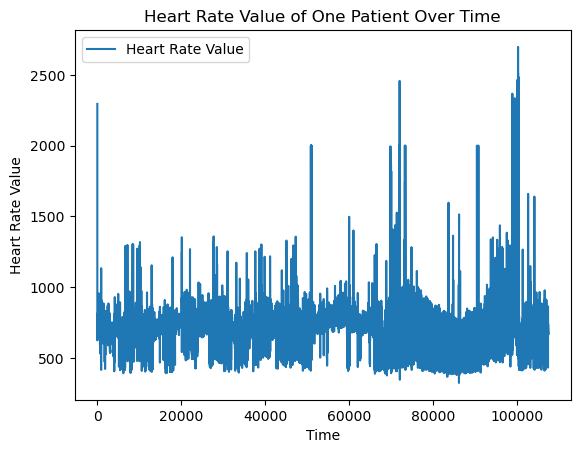

In [8]:
# visualize the time series
plt.plot(df_patient_hr['HRV'], label='Heart Rate Value')
plt.xlabel('Time')
plt.ylabel('Heart Rate Value')
plt.legend()
plt.title('Heart Rate Value of One Patient Over Time')
plt.show();

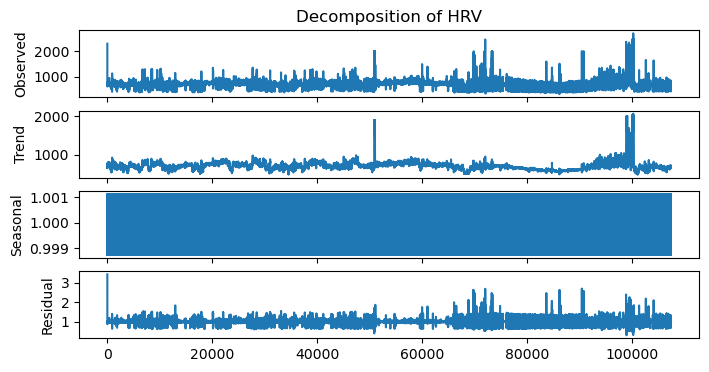

In [9]:
# Checking out the decompositions

# setting the period makes the assumption that the seasonal trend should happen every "period" units (e.g. 10 years, or 5 days)
# can change model='multiplicative' to see if there's a change in seasonal trend
decomp1 = seasonal_decompose(df_patient_hr['HRV'], period=10, model='multiplicative', extrapolate_trend='freq')
# decomp2 = seasonal_decompose(data['Close'], period=5, model='additive', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of HRV')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

- no patterns in residual

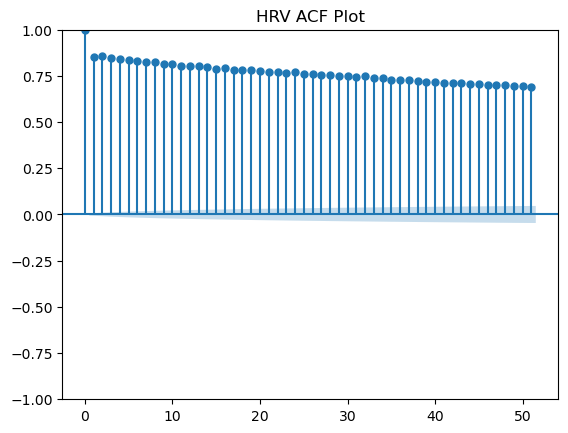

In [10]:
# Autocorrelation Function
# This is used to determine the appropriate lag

# use the original data
series = df_patient_hr['HRV']
plot_acf(series, title = 'HRV ACF Plot')
plt.show();
# Looks like even up to a lag of 10 could provide significant information about the ensuing years

C:\Users\miche\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


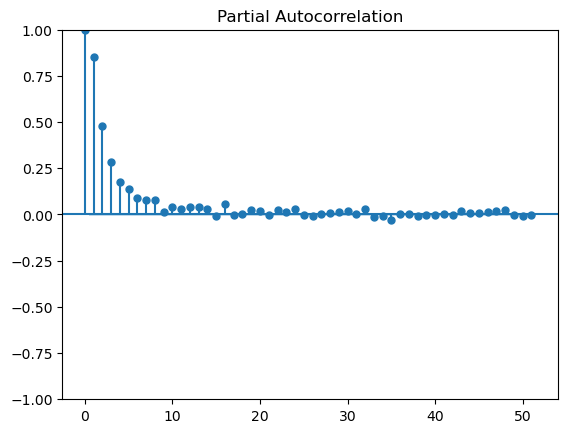

In [11]:
# plot partial autocorrelation function (PACF)
# PACF drops faster, therefore AR model should be better?
plot_pacf(series)
plt.show();

- AR model may be better

# Split data into training and testing set

In [12]:
# Split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
# Take instead the first 80% for the training, then we'll see if the first 80% of MLB history can be used to predict the next 20%
train_size = int(.8 * len(df_patient_hr))
train_data = df_patient_hr[:train_size]
test_data = df_patient_hr[train_size:]

# put the y feature (the current SO9) in arrays
y_train = np.array(train_data['HRV']).reshape(-1,1)
y_test = np.array(test_data['HRV']).reshape(-1,1)

# AR Model

In [13]:
# fit using packages (should do this manually if AR model is good)
# Using statsmodels AutoReg function

ar_model = AutoReg(y_train, lags=50, trend='n') # the default is to add an intercept (or, trend='c'), 
# using trend='n' is more in line with traditional AR(p) models, but may result in a nonstationary model
ar_results = ar_model.fit()

In [14]:
ar_results.params
ar_results.roots

array([ 1.00005878e+00-0.j        ,  1.08632433e+00-0.14868466j,
        1.08632433e+00+0.14868466j,  1.08787070e+00-0.2978849j ,
        1.08787070e+00+0.2978849j ,  1.04532163e+00-0.40459367j,
        1.04532163e+00+0.40459367j,  9.65190505e-01-0.5195094j ,
        9.65190505e-01+0.5195094j ,  7.39466987e-01-0.73913861j,
        7.39466987e-01+0.73913861j,  8.71155092e-01-0.63357324j,
        8.71155092e-01+0.63357324j,  1.39192653e+00-0.j        ,
        6.44184159e-01-0.86337752j,  6.44184159e-01+0.86337752j,
        5.31051652e-01-0.9353474j ,  5.31051652e-01+0.9353474j ,
        4.00514024e-01-0.99678634j,  4.00514024e-01+0.99678634j,
        2.74887683e-01-1.04920409j,  2.74887683e-01+1.04920409j,
        1.59642369e-01-1.0604102j ,  1.59642369e-01+1.0604102j ,
       -1.05581087e-03-1.03605215j, -1.05581087e-03+1.03605215j,
       -1.62930976e-01-1.04695091j, -1.62930976e-01+1.04695091j,
       -3.12451706e-01-1.03453784j, -3.12451706e-01+1.03453784j,
       -4.36369848e-01-1.

In [15]:
# the predictions
ar_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': ar_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

,pred HRV
Time,
85979,568.834720
85980,569.080537
85981,568.351562
85982,568.815937
85983,569.306362


In [16]:
print(len(pred_data))
print(len(y_test))

21495
21495


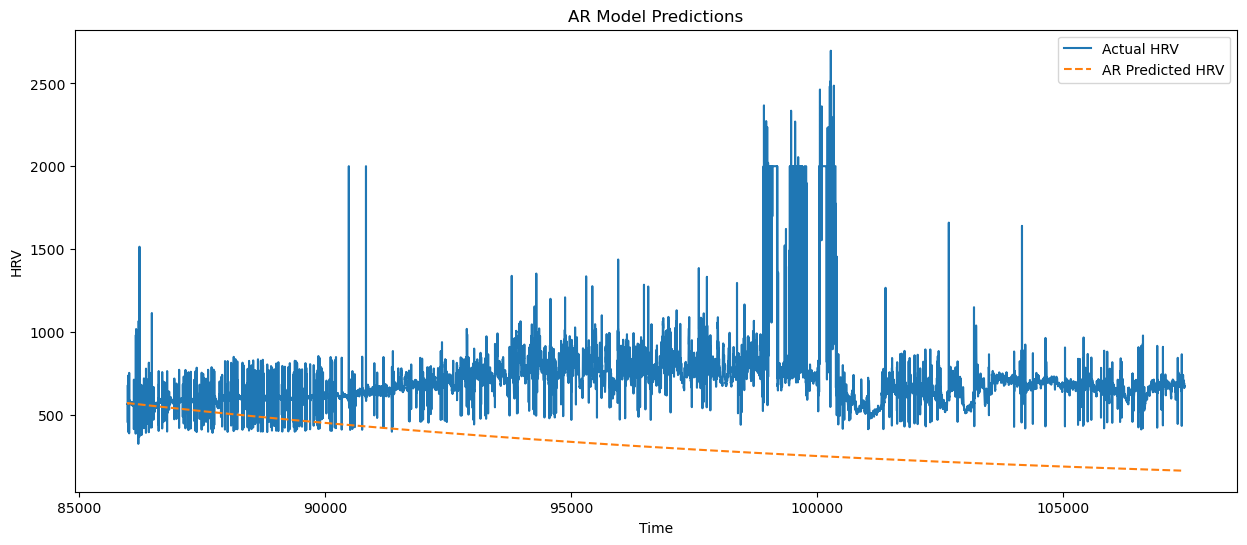

In [17]:
# make the plot
plt.figure(figsize=(15, 6))

plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'AR Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('AR Model Predictions')
plt.show();

In [18]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 397.84
Root Mean Squared Error: 490.56


# MA model

In [ ]:
# For AR(p), you would do ARIMA(series, order=(p, 0, 0))
# For MA(q), you would do ARIMA(series, order=(0, 0, q))
# For ARIMA(p,q), it's ARIMA(series, order=(p, 0, q))
# And for ARIMA(p, d, q), it's ARIMA(series, order=(p,d,q))
# though you should investigate a little bit more outside of class just what combining them entails before trusting
# here's the docs: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# CHANGE NUMBER HERE
ma_model = ARIMA(y_train, order=(0, 0, 50)) # here is the MA(1) model
ma_results = ma_model.fit()

#summary of the model
ma_results.summary()
# Interpretation: coef. of the constant is 3.8981 which works as the mean of the dataset 
# coefficient of the noise value ma.L1 is .7172, but the P>|z| tells us that this has a significant impact on the output
# (note, if we used the differenced data, the constant is no longer interpretable as the mean/level of the series)

In [ ]:
# getting the predictions works the same as in AR(p)
# but note that MA(q) models are even worse at long-term broadcasting
# and that everything after order q=1 is simply predicted at the mean
ma_pred = ma_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': ma_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

In [ ]:
plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'MA Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('MA Model Predictions')
plt.show();

# ARIMA Model

In [4]:
# For AR(p), you would do ARIMA(series, order=(p, 0, 0))
# For MA(q), you would do ARIMA(series, order=(0, 0, q))
# For ARIMA(p,q), it's ARIMA(series, order=(p, 0, q))
# And for ARIMA(p, d, q), it's ARIMA(series, order=(p,d,q))
# though you should investigate a little bit more outside of class just what combining them entails before trusting
# here's the docs: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# CHANGE NUMBER HERE
arima_model = ARIMA(y_train, order=(10, 0, 5))
arima_results = arima_model.fit()

#summary of the model
arima_results.summary()
# Interpretation: coef. of the constant is 3.8981 which works as the mean of the dataset 
# coefficient of the noise value ma.L1 is .7172, but the P>|z| tells us that this has a significant impact on the output
# (note, if we used the differenced data, the constant is no longer interpretable as the mean/level of the series)

C:\Users\miche\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\miche\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\miche\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                85979
Model:                ARIMA(10, 0, 5)   Log Likelihood             -453222.508
Date:                Tue, 01 Apr 2025   AIC                         906479.017
Time:                        16:29:28   BIC                         906638.168
Sample:                             0   HQIC                        906527.646
                              - 85979                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        704.6696      8.153     86.426      0.000     688.689     720.650
ar.L1         -0.7437      0.149     -4.994      0.000      -1.036      -0.452
ar.L2          0.3487      0.127      2.745      0.006       0.100       0.598
ar.L3          1.1652      0.051     22.919      0.000       1.066       1.265
ar.L4          0.7670      0.180      4.255      0.000       0.414       1.120
ar.L5         -0.1494      0.126     -1.187      0.235      -0.396       0.097
ar.L6         -0.1722      0.014    -12.298      0.000      -0.200      -0.145
ar.L7         -0.1430      0.027     -5.390      0.000      -0.195      -0.091
ar.L8         -0.0638      0.023     -2.772      0.006      -0.109      -0.019
ar.L9         -0.0362      0.012     -3.136      0.002      -0.059      -0.014
ar.L10         0.0154      0.007      2.129      0.033       0.001       0.030
ma.L1          0.8918      0.149      5.990      0.000       0.600       1.184
ma.L2          0.0032      0.149      0.022      0.983      -0.289       0.295
ma.L3         -0.7941      0.013    -63.207      0.000      -0.819      -0.769
ma.L4         -0.6344      0.121     -5.245      0.000      -0.871      -0.397
ma.L5          0.0519      0.103      0.505      0.613      -0.149       0.253
sigma2      2220.8293      1.443   1538.861      0.000    2218.001    2223.658
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):          88054033.01
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                             3.50
Prob(H) (two-sided):                  0.00   Kurtosis:                       159.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [5]:
# getting the predictions works the same as in AR(p)
# but note that MA(q) models are even worse at long-term broadcasting
# and that everything after order q=1 is simply predicted at the mean
arima_pred = arima_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': arima_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

,pred HRV
Time,
85979,571.991108
85980,572.708956
85981,573.437762
85982,574.495517
85983,575.073888


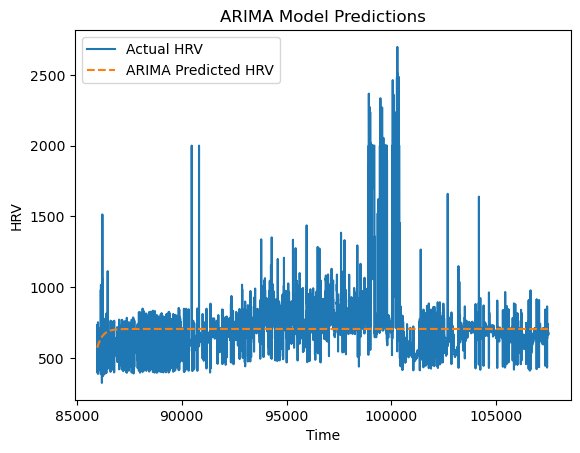

In [6]:
plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'ARIMA Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.show();

In [7]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 115.67
Root Mean Squared Error: 242.78


The mean absolute error and root mean squared error for ARIMA (using both AR and MA together) is better than when just using AR.